In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# read in data and look at target variable
data = pd.read_csv('data/LoanStats3a.csv')

/var/folders/0w/pvg4kzqx7757341_gst5jz6h0000gp/T/ipykernel_58170/71372388.py:2: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/LoanStats3a.csv')


In [3]:
data.shape

(42538, 144)

In [4]:
TARGET_VAR = 'loan_status'

<Axes: xlabel='loan_status', ylabel='Count'>

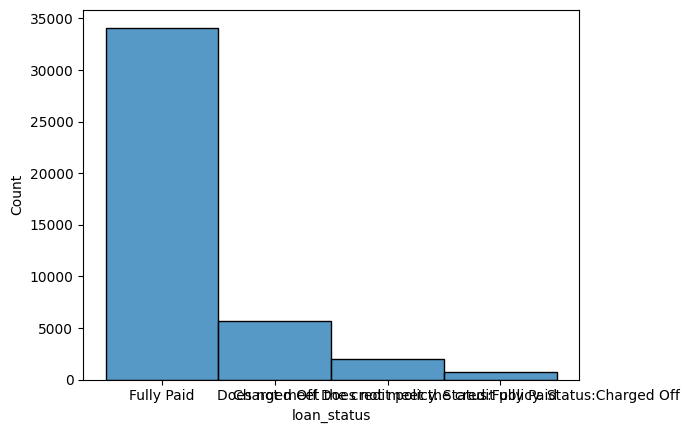

In [5]:
sns.histplot(data[TARGET_VAR])

We are looking to determine whether or not the loan is expected to be paid off, so we can binarize these into "Fully Paid" and everything else. Inspect the data a bit more.

In [6]:
categorical_features = [x for x in data.dtypes.keys() if data.dtypes[x] == object]
numeric_features = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
print(f'CATEGORICALS: {len(categorical_features)}')
print(sorted(categorical_features))
print(f'NUMERIC: {len(numeric_features)}')
print(sorted(numeric_features))

CATEGORICALS: 29
['addr_state', 'application_type', 'debt_settlement_flag', 'debt_settlement_flag_date', 'desc', 'disbursement_method', 'earliest_cr_line', 'emp_length', 'emp_title', 'grade', 'hardship_flag', 'home_ownership', 'initial_list_status', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_pymnt_d', 'loan_status', 'next_pymnt_d', 'purpose', 'pymnt_plan', 'revol_util', 'settlement_date', 'settlement_status', 'sub_grade', 'term', 'title', 'verification_status', 'zip_code']
NUMERIC: 115
['acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc', 'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'deferral_term', 'delinq_2yrs', 'delinq_amnt', 'dti', 'dti_joint', 'funded_amnt', 'funded_amnt_inv', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason'

In [7]:
for cat in categorical_features:
    print(cat.upper())
    print(data[cat].describe())

TERM
count          42535
unique             2
top        36 months
freq           31534
Name: term, dtype: object
INT_RATE
count      42535
unique       394
top       10.99%
freq         970
Name: int_rate, dtype: object
GRADE
count     42535
unique        7
top           B
freq      12389
Name: grade, dtype: object
SUB_GRADE
count     42535
unique       35
top          B3
freq       2997
Name: sub_grade, dtype: object
EMP_TITLE
count       39909
unique      30658
top       US Army
freq          139
Name: emp_title, dtype: object
EMP_LENGTH
count         41423
unique           11
top       10+ years
freq           9369
Name: emp_length, dtype: object
HOME_OWNERSHIP
count     42535
unique        5
top        RENT
freq      20181
Name: home_ownership, dtype: object
VERIFICATION_STATUS
count            42535
unique               3
top       Not Verified
freq             18758
Name: verification_status, dtype: object
ISSUE_D
count      42535
unique        55
top       Dec-11
freq        2

We have some categorical and many numeric features. After inspecting the data, we find that we need to convert some categoricals to either binary or numeric. We will one-hot-encode any categorical features that have only a small number of classes. Lastly, we'll drop any remaining features that have very few classes or are largely NaN. 

In [8]:
DROP = ['member_id'] # drop member id, add more to this list as we go
# take only instances that aren't missing target var
data = data[data[TARGET_VAR].notna()].copy()
# replace NaN with 0
data.fillna(0, inplace=True)

# Convert target vars to 0 and 1
data['loan_status'] = data['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# convert Y/N to 0 and 1
data['debt_settlement_flag'] = data['debt_settlement_flag'].apply(lambda x: 1 if x == 'Y' else 0)

# Convert percentage strings to floats
for var in ['revol_util', 'int_rate']:
    data[var] = data[var].apply(lambda x: float(str(x).replace('%', '')))

# Convert "N months" to int
data['term'] = data['term'].apply(lambda x: int(str(x).replace(' months', '')))

# Convert letter grade to numeric
letter_mapping = {n: i for i, n in enumerate(list('ABCDEFG'))}
data['grade'] = data['grade'].apply(lambda x: letter_mapping[x])

# Engineer some more features that could be helpful
data['diff_installment_last_pymnt'] = data['installment'] - data['last_pymnt_amnt'] # difference between monthly installent amount and amount paid
data['total_repayment_amnt'] = data['installment'] * data['term'] # total amount to be repaid
data['fund_amt_per_month'] = data['funded_amnt'] / data['term'] # amount loaned broken down by month

for f in data.columns:
    if data[f].value_counts().shape[0] == 1:
        DROP.append(f)

# and then a couple others that had very few classes or data was missing for the vast majority of instances
DROP.extend(
    [
        'tax_liens', 
        'delinq_amnt', 
        'settlement_date', 
        'debt_settlement_flag_date', 
        'settlement_status', 
        'verification_status'
    ]
)
# Next payment date seems irrelevant for predicting loan default
DROP.append('next_pymnt_d')

# Drop other categorical variables for now--we'll return to them later
DROP.extend(
    [
        'last_credit_pull_d', 
        'last_pymnt_d', 
        'earliest_cr_line', 
        'issue_d', 
        'desc',
        'home_ownership',
        'purpose',
        'settlement_status',
        'verification_status',
        'addr_state',
        'zip_code',
        'emp_length',
        'emp_title',
        'sub_grade',
        'title'
    ]
)

target = data[TARGET_VAR]
df = data.loc[:,list(set(data.columns) - set(DROP + [TARGET_VAR]))]

df.shape

(42535, 35)

Train the model so we can look at some residuals.

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report

X = df.values
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

clf = LogisticRegression()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1611
           1       0.95      1.00      0.97      6896

    accuracy                           0.96      8507
   macro avg       0.96      0.89      0.92      8507
weighted avg       0.96      0.96      0.95      8507



/Users/ellynkeith/PycharmProjects/ML_AI/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy is excellent. F1 for class 1 also looks good. The priority here is clearly improving recall for class 0. First, check some goodness-of-fit metrics and plot residuals.

In [11]:
from sklearn.metrics import mean_squared_error

y_pred = clf.predict_proba(X_test)[:, 1]
residuals = y_test - y_pred

# Number of observations and number of predictors
n = len(y)
p = X.shape[1]

mse = mean_squared_error(y_test, y_pred)
ssr = np.sum((y_pred - np.mean(y)) ** 2)
rss = np.sum(residuals ** 2)
f_stat = (ssr / p) / (rss / (n - p - 1))

print('Mean Squared Error:', mse, '\nF-statistic:', f_stat)

Mean Squared Error: 0.04179501830636308 
F-statistic: 3337.9823541562246


MSE is low and F-statistic is high, so that's good.

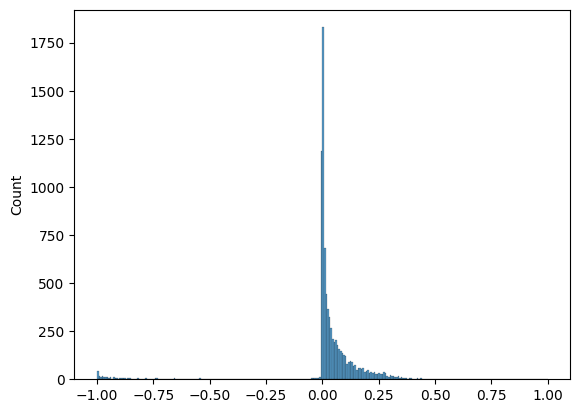

In [12]:
sns.histplot(residuals)
plt.show()

This plot of residuals tells the same story as the classification report: we have a positive bias, wherein we underestimate the probability of the positive class. Perform error analysis on these FNs.

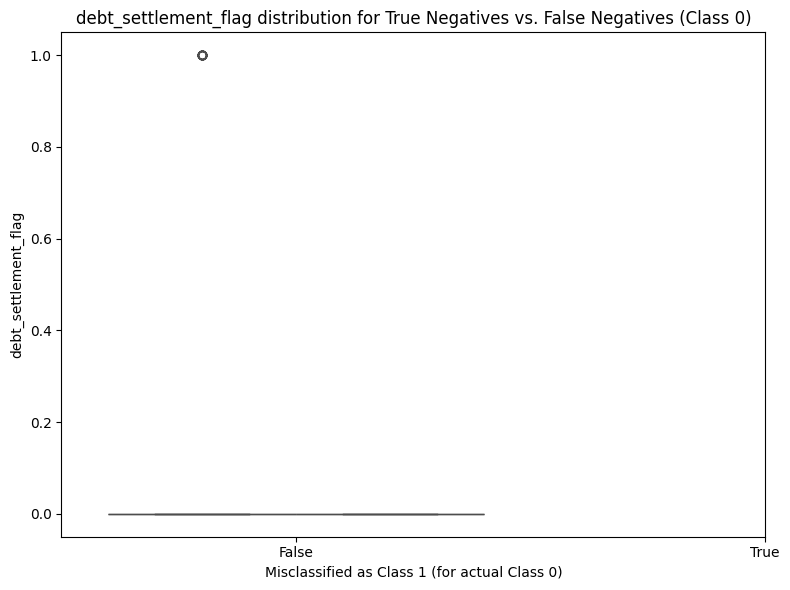

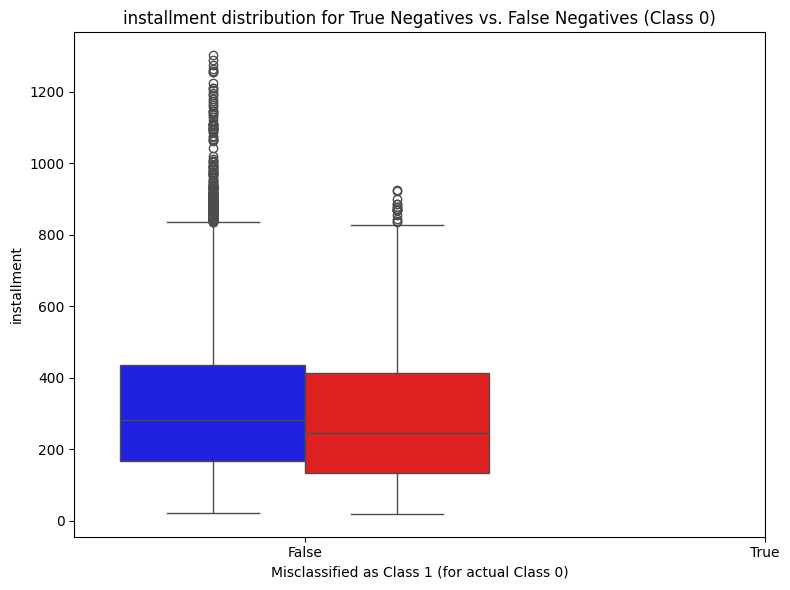

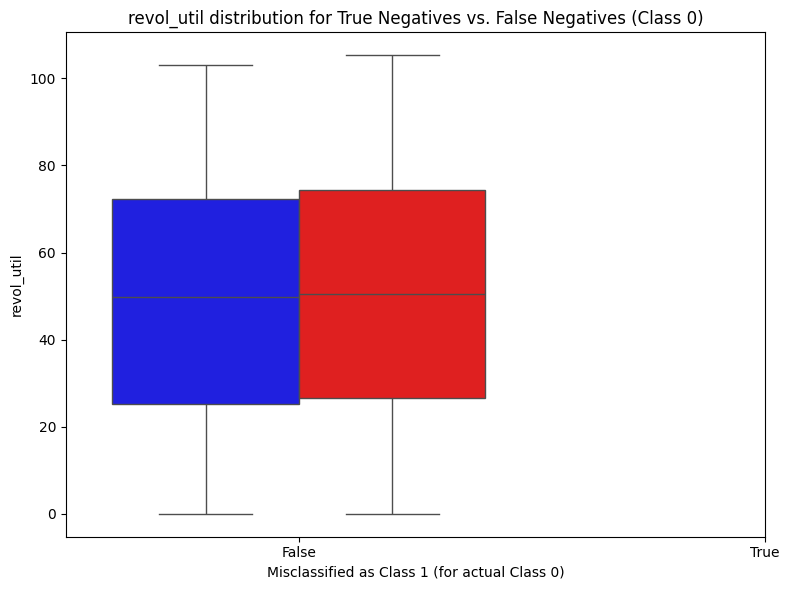

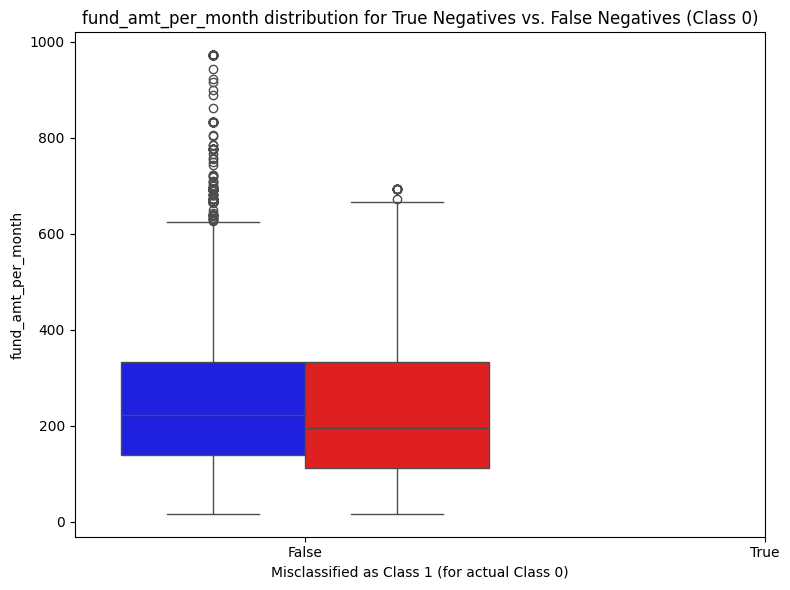

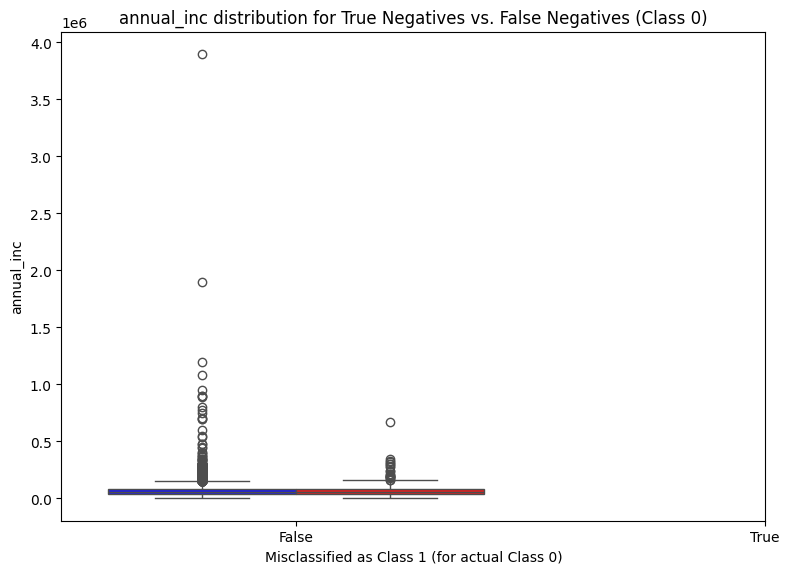

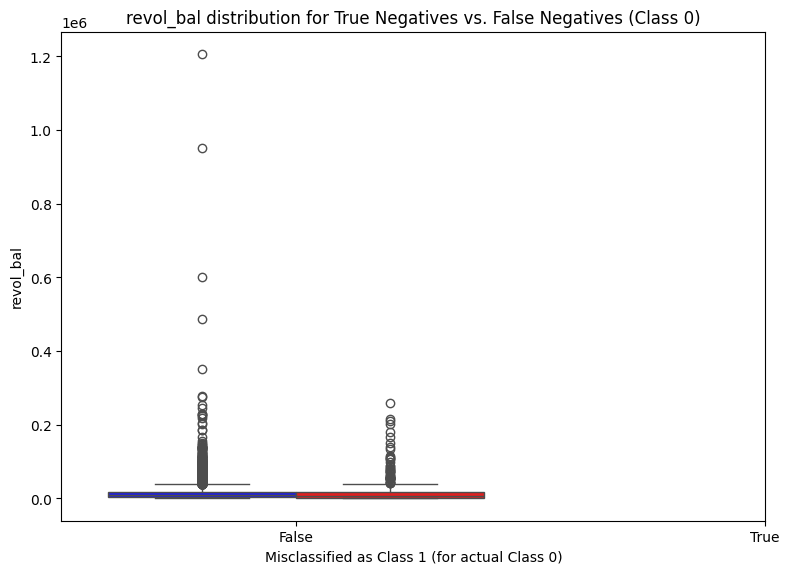

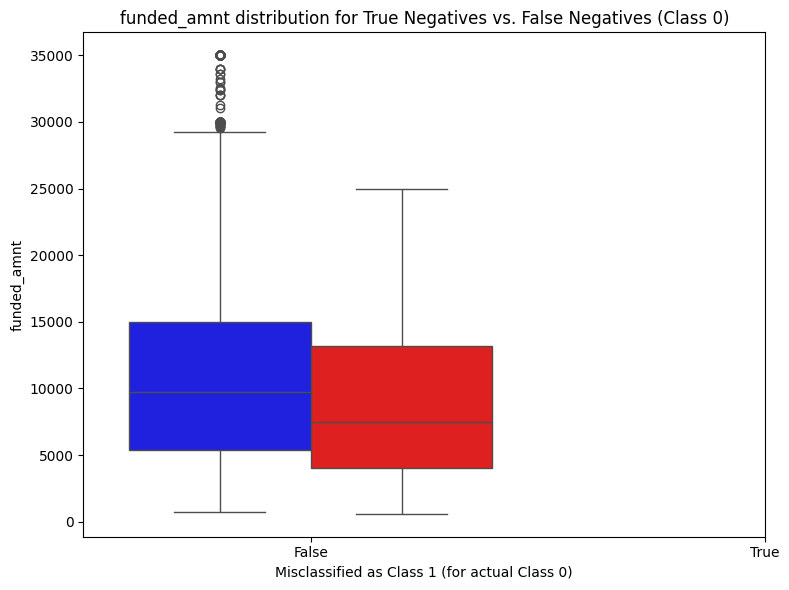

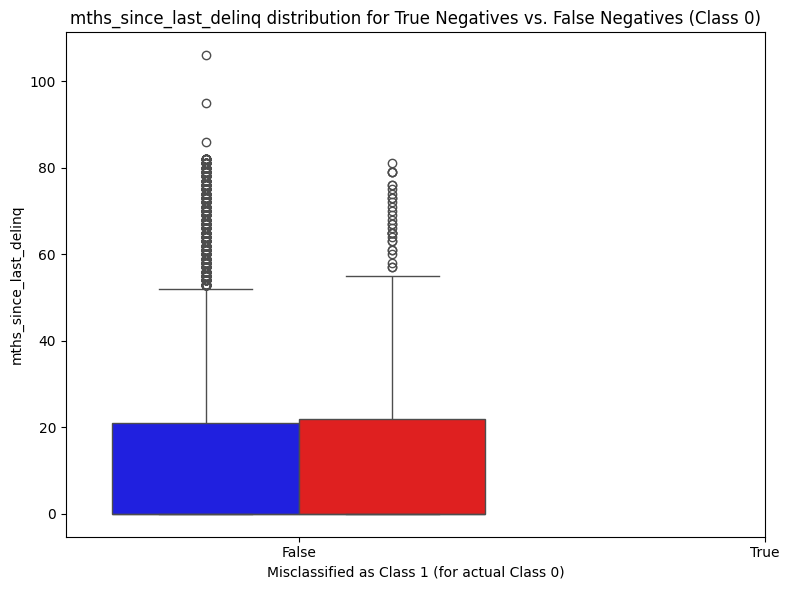

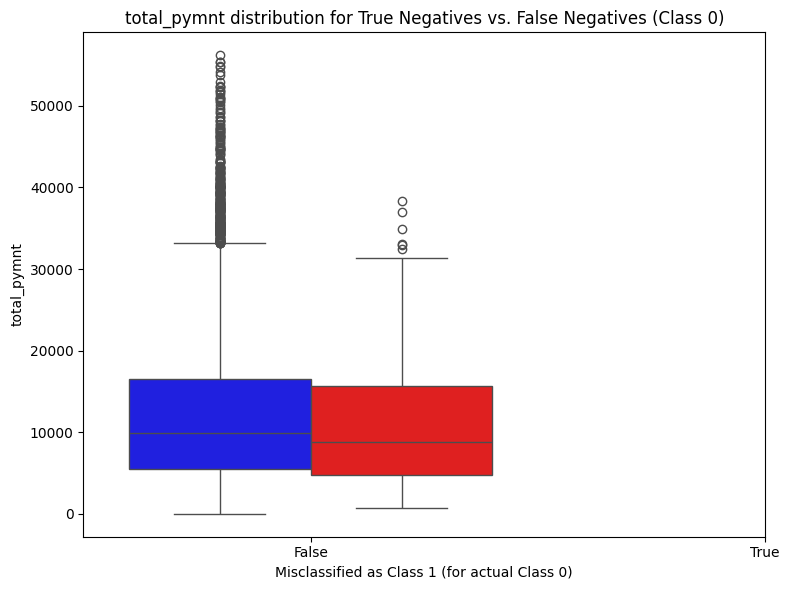

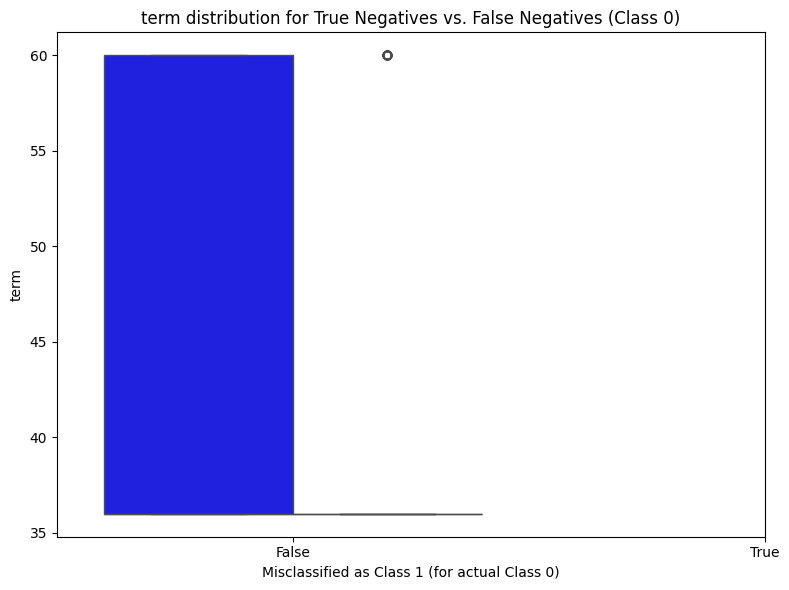

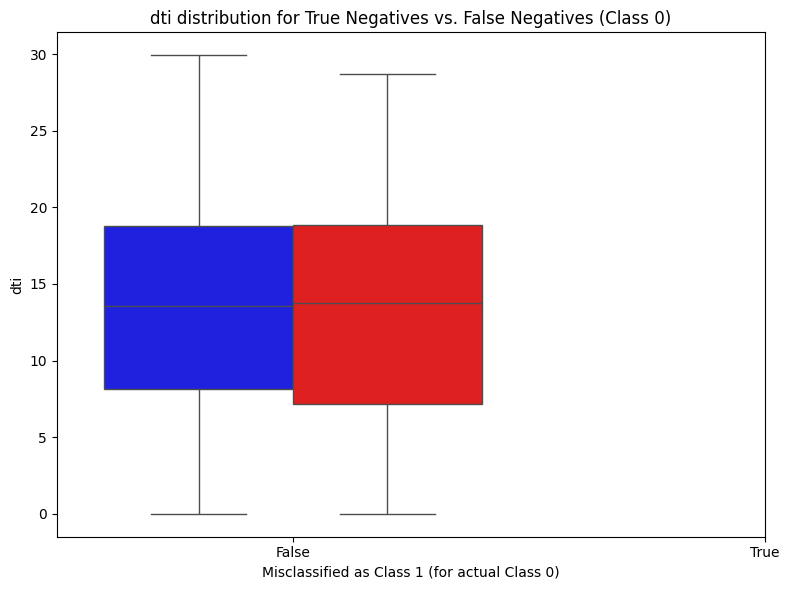

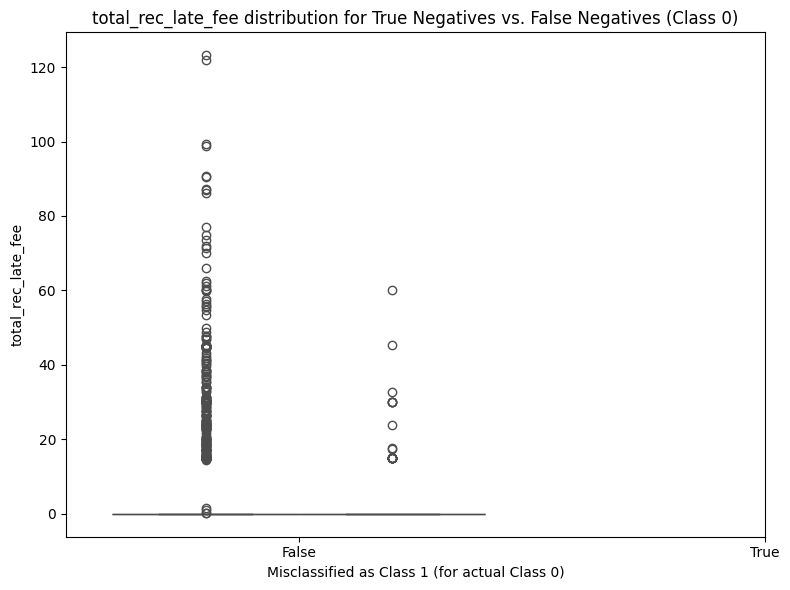

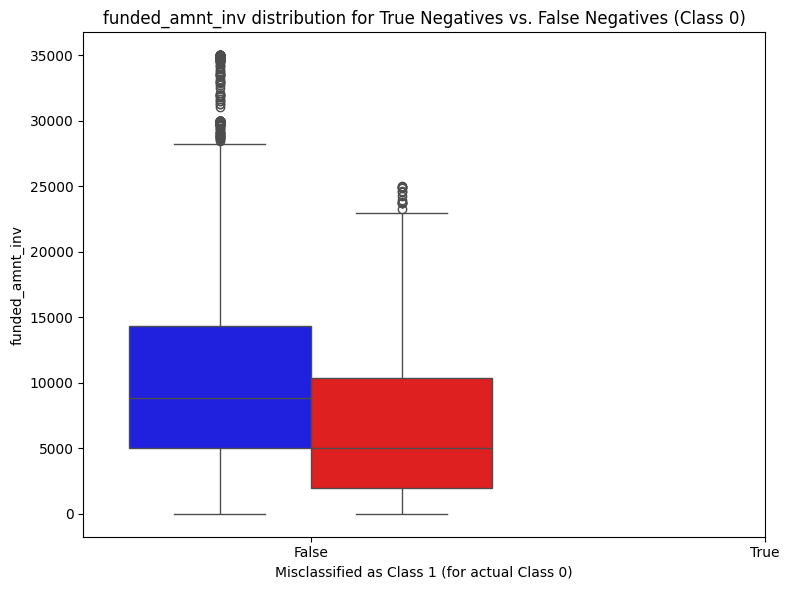

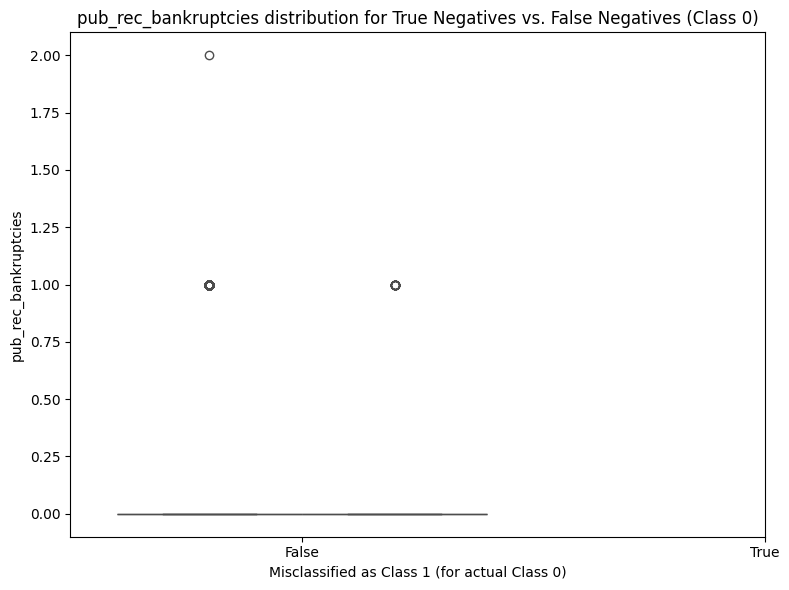

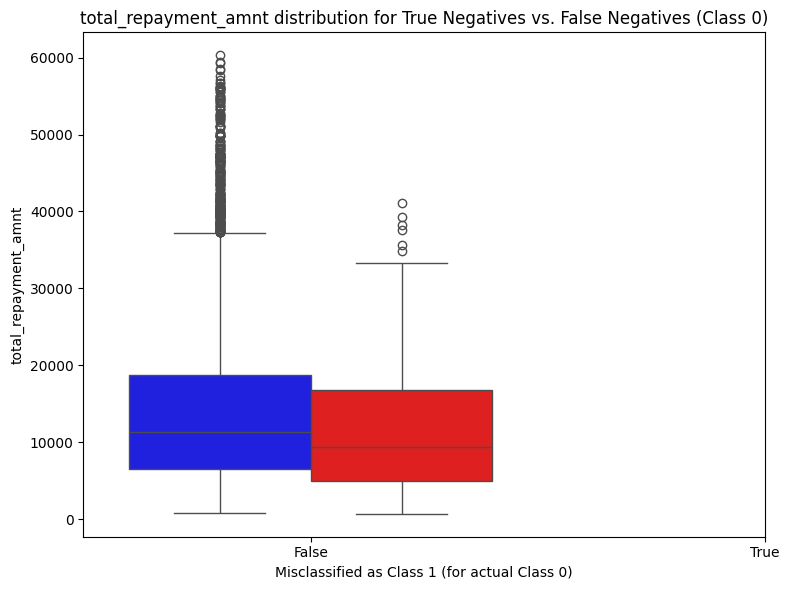

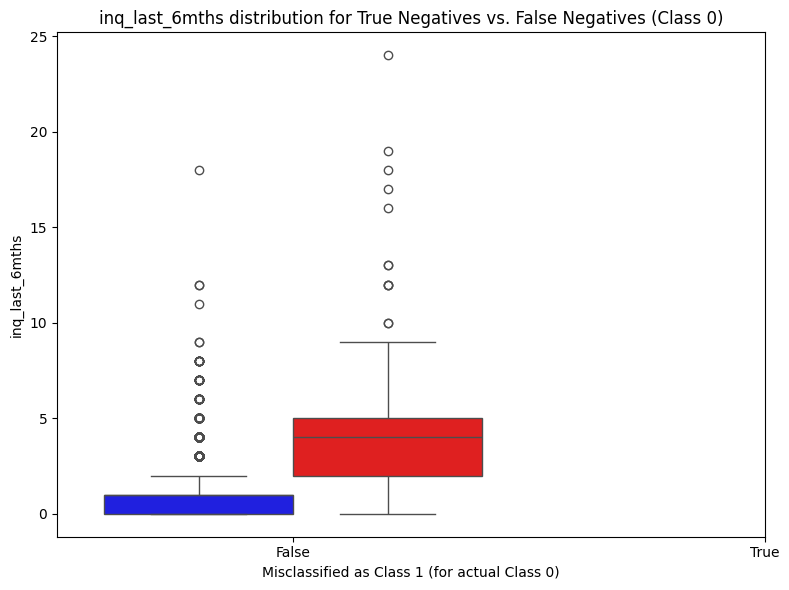

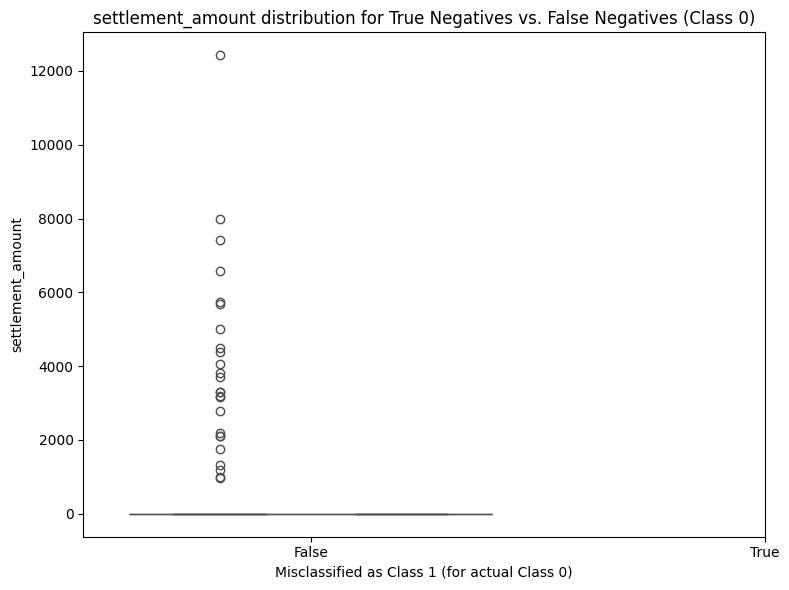

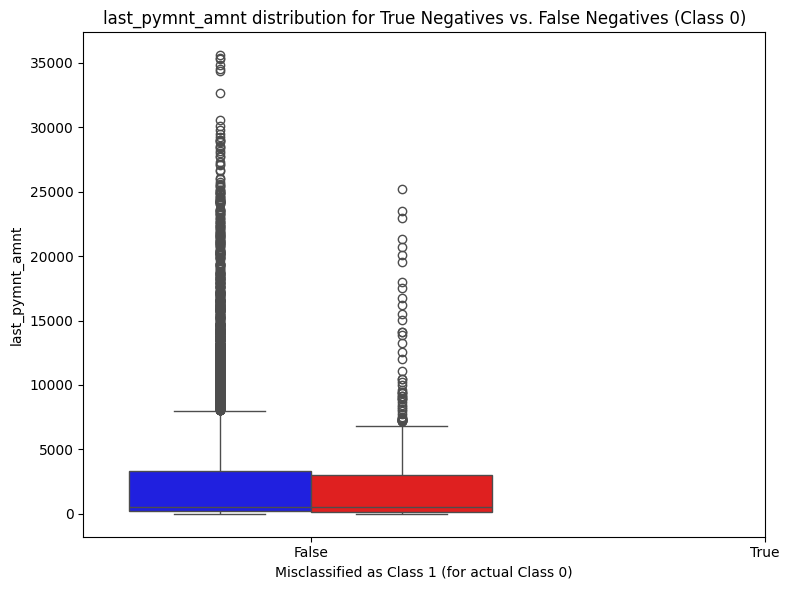

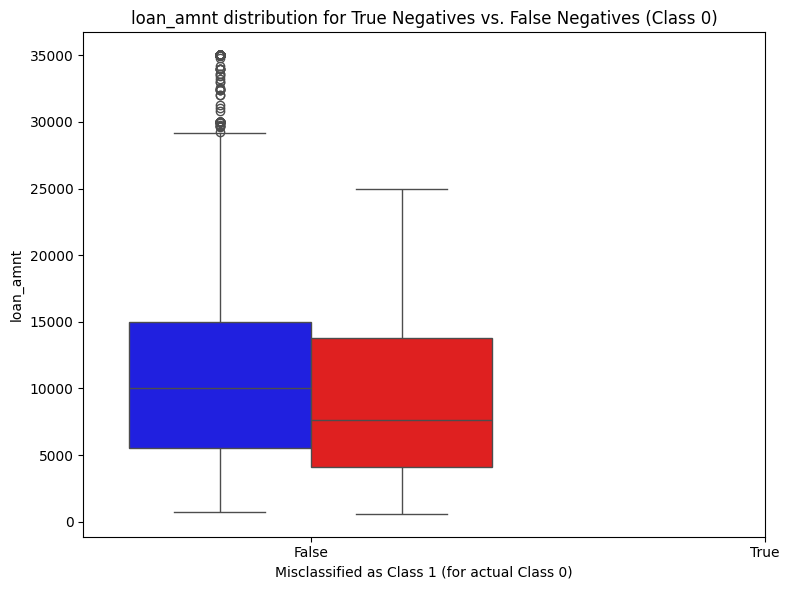

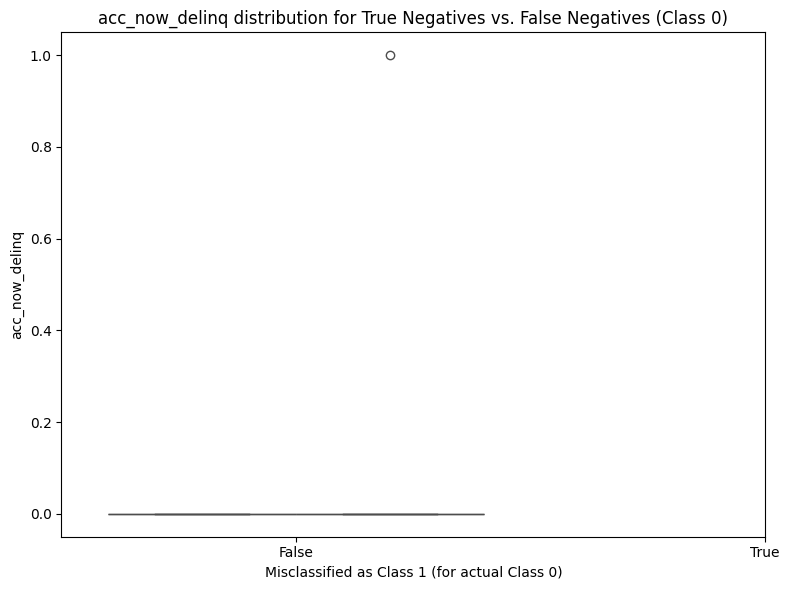

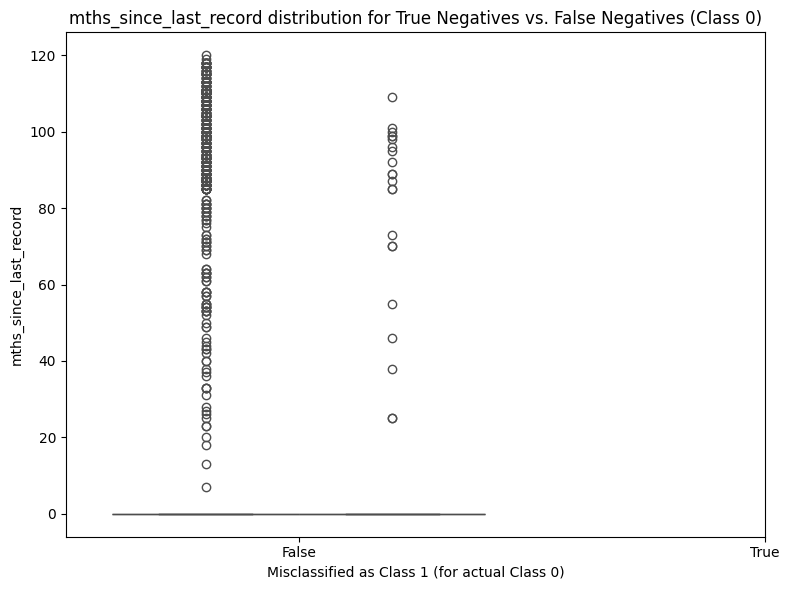

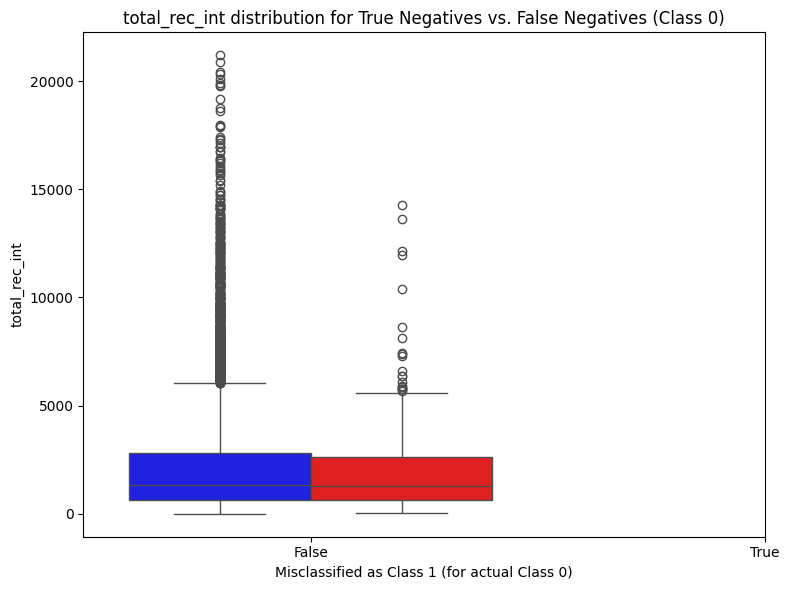

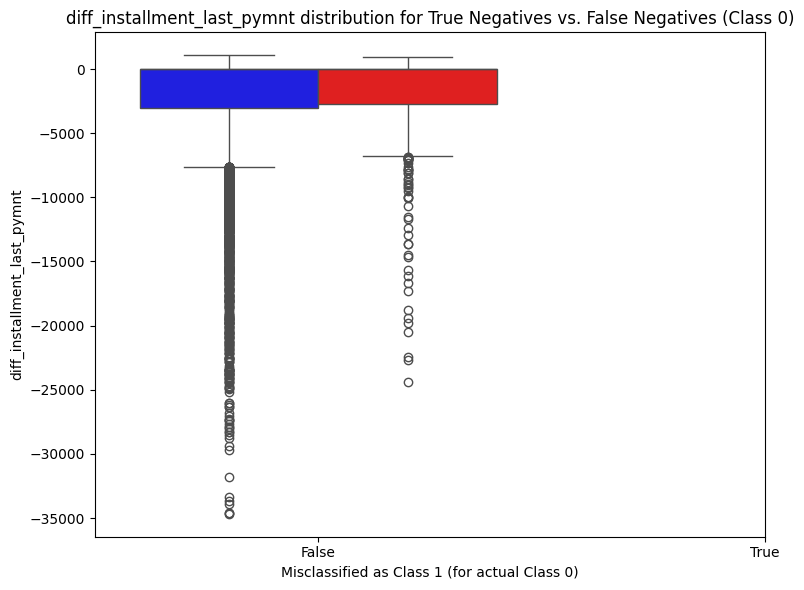

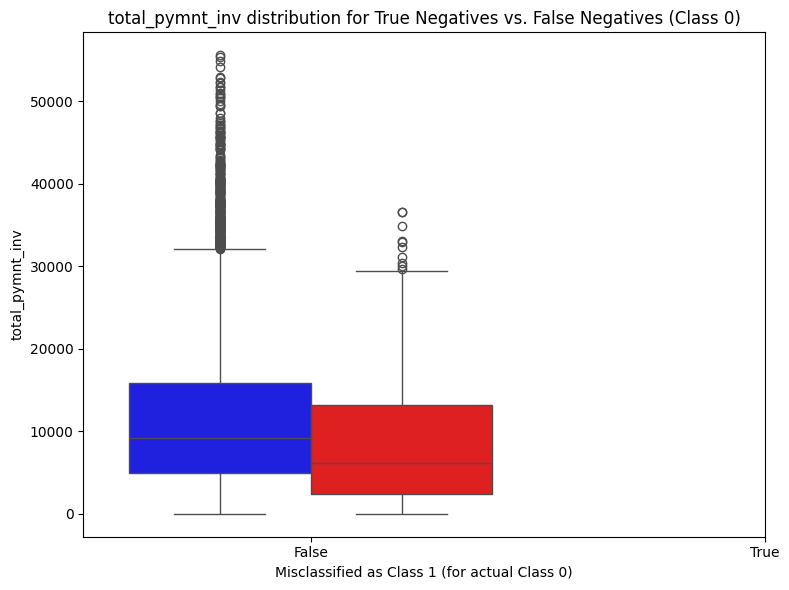

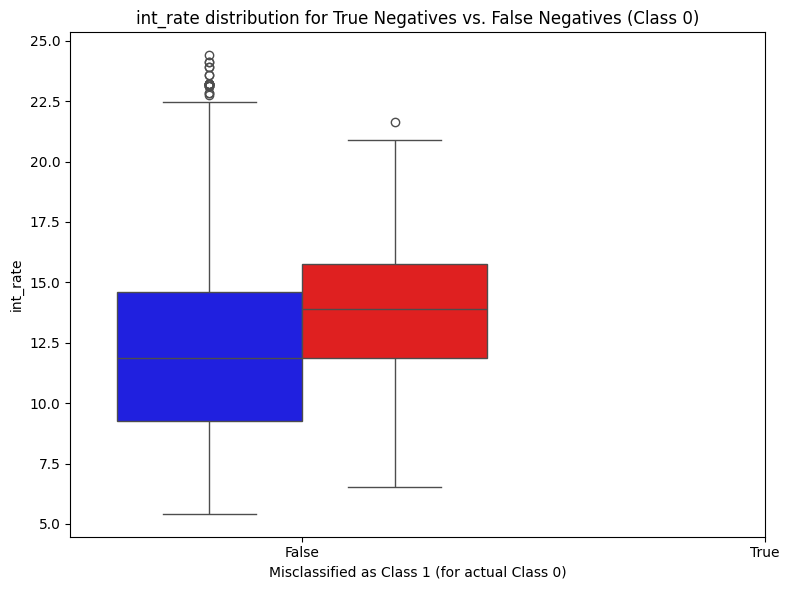

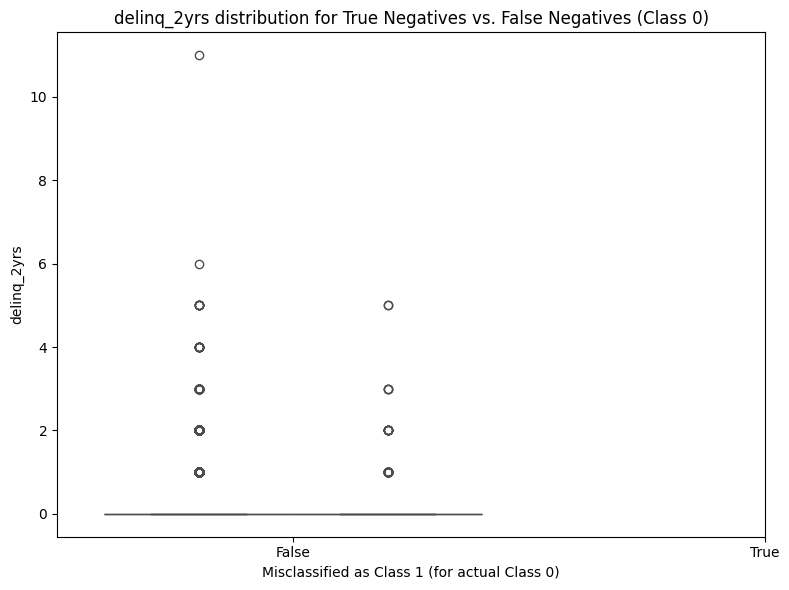

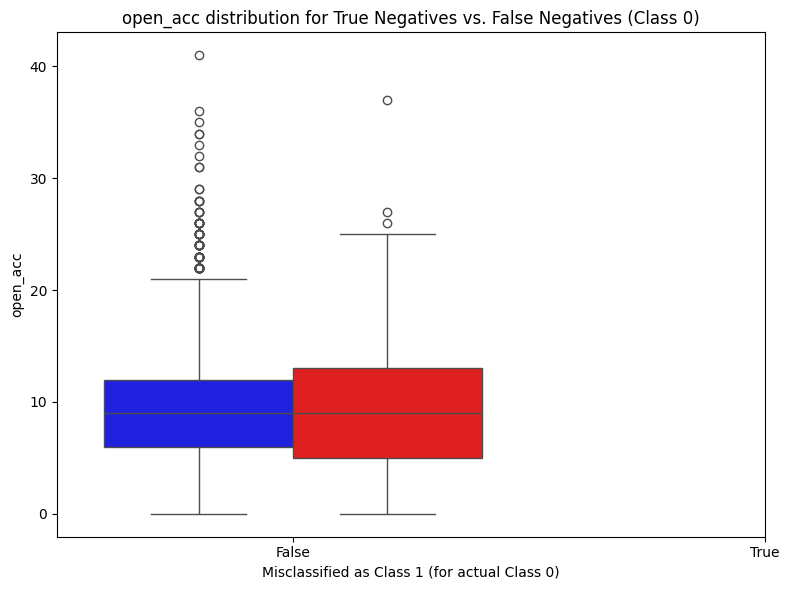

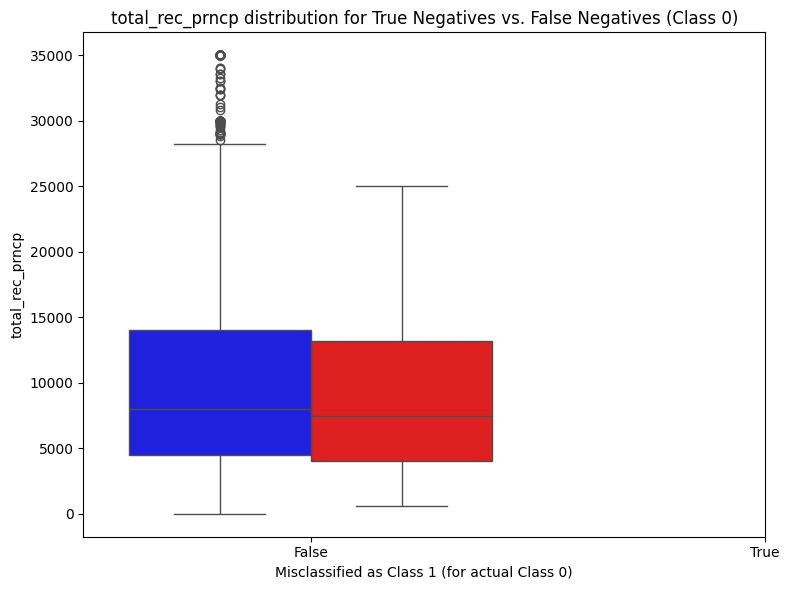

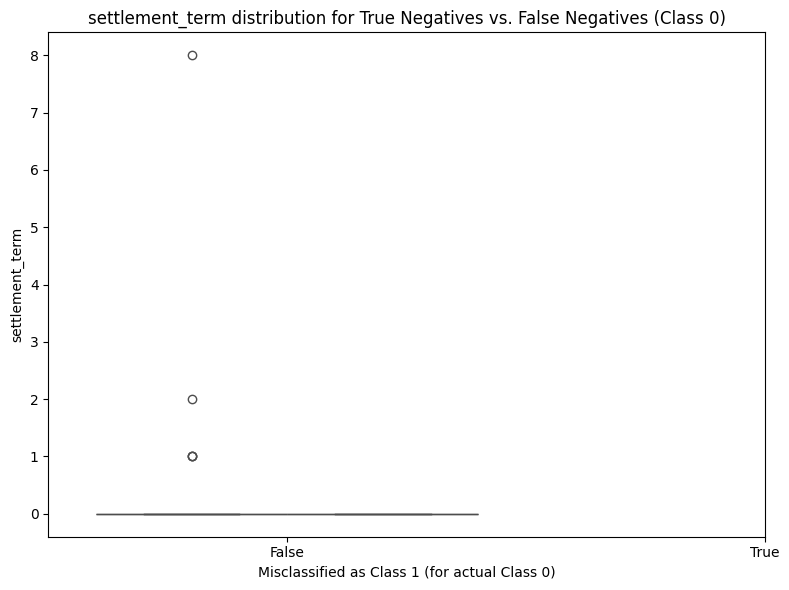

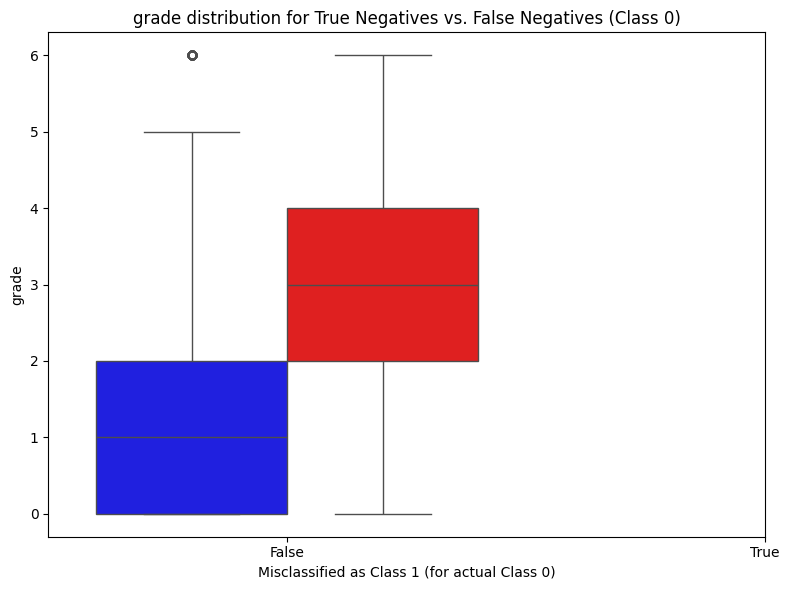

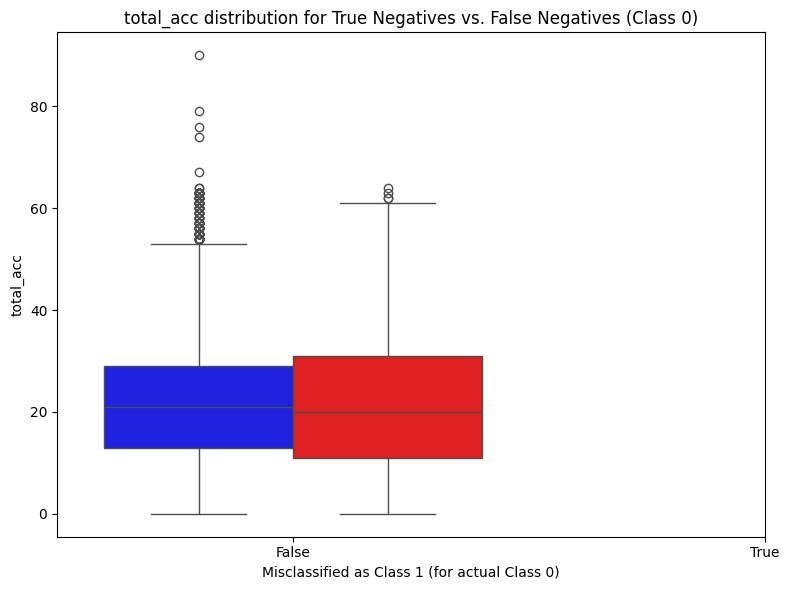

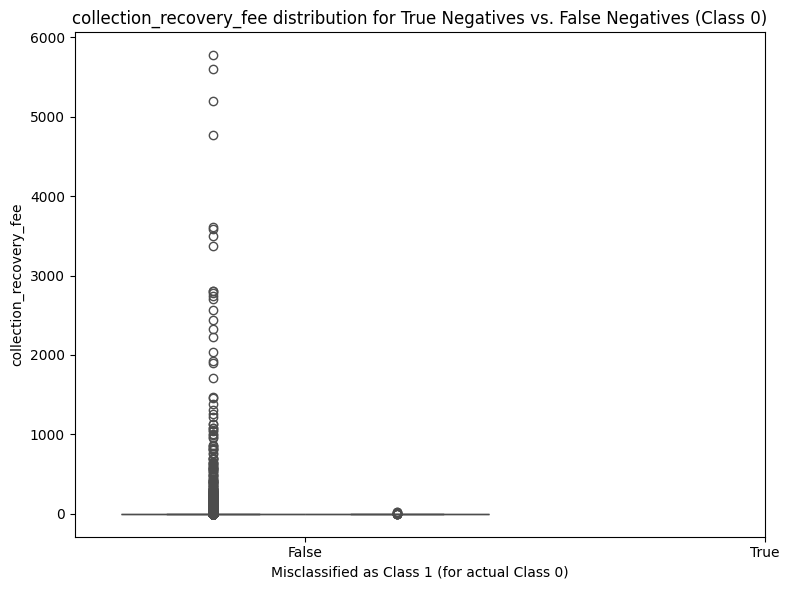

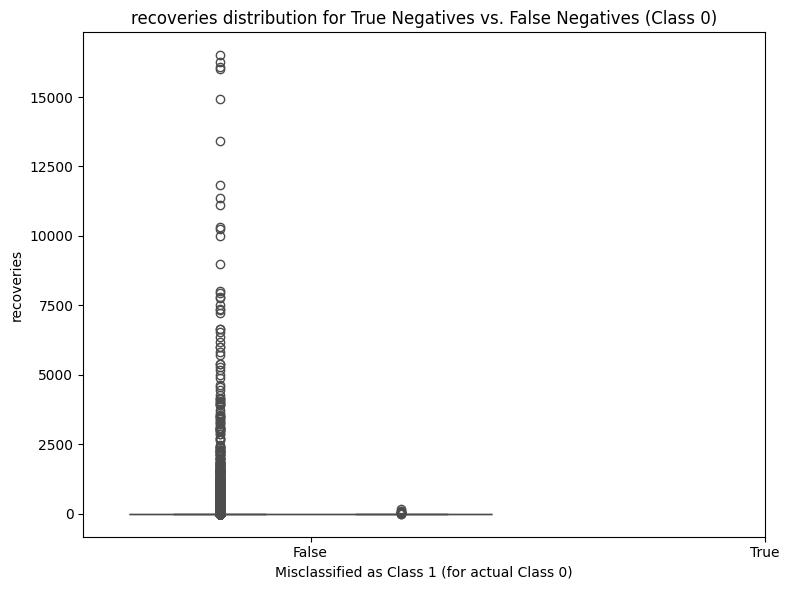

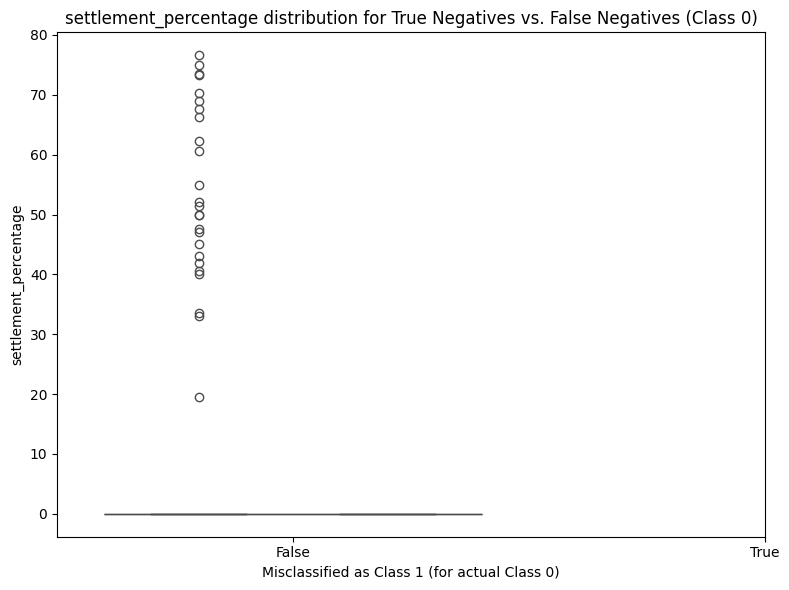

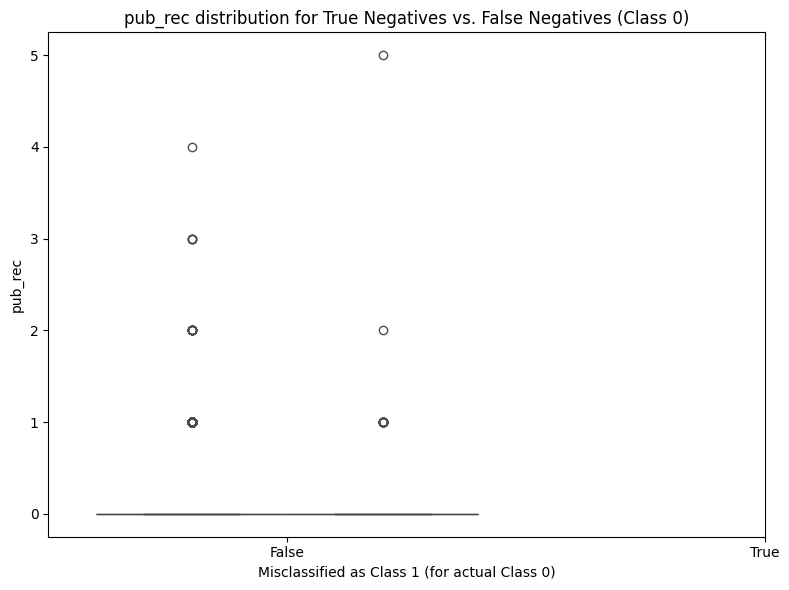

In [28]:
temp_df = pd.DataFrame(X_test, columns=df.columns)
temp_df['y_expected'] = y_test
temp_df['y_pred'] = clf.predict(X_test)
temp_df['is_fn'] = (temp_df['y_expected'] == 0) & (temp_df['y_pred'] == 1)
temp_df['is_fn'] = temp_df['is_fn'].astype(str)

for i, feature_name in enumerate(temp_df.columns[:-3]):
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=temp_df.iloc[:, i], x=None, hue=temp_df['is_fn'], data=temp_df, palette={'False': 'blue', 'True': 'red'}, legend=False)
    plt.title(f'{feature_name} distribution for True Negatives vs. False Negatives (Class 0)')
    plt.xlabel('Misclassified as Class 1 (for actual Class 0)')
    plt.ylabel(feature_name)
    plt.xticks([0, 1], ['False', 'True'])
    plt.tight_layout()
    plt.show()

In [ ]:
_df = df.copy()
_df[TARGET_VAR] = target
_df['color'] = ['FNs' if abs(x) < 0.4 else 'TPs' for x in residuals]

features = [c for c in _df.columns if c not in ['loan_status', 'color']]
charged_off = _df[_df['loan_status'] == 0]

fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(10, 5 * len(features)))
palette = {
    'FNs': 'red',
    'TPs': 'blue'
}
for i, feature in enumerate(features):
  ax = axes[i]
  sns.kdeplot(
        data=charged_off,
        x=charged_off[feature],
        hue='color',
        ax=ax,
        palette=palette,
        fill=True  # Optional: fills the density curve
    )
  ax.set_xlabel(feature)
  ax.set_ylabel('Loan Status')
  ax.set_title(f'{feature} vs. loan status')

plt.tight_layout()
plt.show()

Look at correlation coefficients to see if we can be informed by them to reduce noise.

In [ ]:
print(pd.DataFrame({
    'feature': df.columns,
    'coef': clf.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False))

While the classification metrics were pretty good, all these correlation coefficients are extremely small. This suggests that the relationship between each feature and the target is more complex than simply linear. Plot the re

In [ ]:
def plot_hist_density_by_target(df, feature_name, target_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature_name, hue=target_name, kde=True)
    plt.title(f'Distribution of {feature_name} by {target_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Density / Frequency')
    plt.legend(title=target_name, labels=['Class 0', 'Class 1'])
    plt.show()

numerical_features = [f for f in df.select_dtypes(include=['number']).columns.tolist() if f in df.columns]

# if 'target' in numerical_features:
#     numerical_features.remove('target')

for feature in ['recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp']:
    plot_hist_density_by_target(data, feature, TARGET_VAR)

These visualizations suggest that some of these features are just adding noise. Others show a strong distribution difference between the 2 classes. Given that initial accuracy was so high, we will try retraining the model with a small subset of features:
total_pymnt
total_rec_int
total_acc
total_rec_prncp
total_repayment_amnt
revol_util
revol_bal
total_pymnt_inv

In [ ]:
features_to_keep = ['total_pymnt', 'total_rec_int', 'total_rec_prncp', 'total_repayment_amnt', 'total_pymnt_inv']
df_subset = data.loc[:,['recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp']]

In [ ]:
df_subset.shape
target.shape

In [ ]:
X = df_subset.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

clf = LogisticRegression()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))